In [3]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(DEVICE)

cuda


Using device: cuda
Classes: ['happy', 'neutral', 'sad']
Epoch 1: Train=56.74% | Val=64.84% | Test=65.68% || TL=0.924 VL=0.824 TeL=0.815
Epoch 2: Train=65.64% | Val=68.84% | Test=68.71% || TL=0.798 VL=0.767 TeL=0.754
Epoch 3: Train=68.89% | Val=70.43% | Test=70.22% || TL=0.751 VL=0.751 TeL=0.732
Epoch 4: Train=70.30% | Val=71.31% | Test=71.34% || TL=0.731 VL=0.737 TeL=0.715
Epoch 5: Train=71.88% | Val=71.72% | Test=71.74% || TL=0.708 VL=0.722 TeL=0.700
Epoch 6: Train=71.84% | Val=72.16% | Test=72.54% || TL=0.699 VL=0.722 TeL=0.696
Epoch 7: Train=73.23% | Val=72.37% | Test=72.10% || TL=0.684 VL=0.706 TeL=0.692
Epoch 8: Train=73.79% | Val=72.05% | Test=72.43% || TL=0.674 VL=0.708 TeL=0.692
Epoch 9: Train=74.02% | Val=72.63% | Test=73.01% || TL=0.665 VL=0.711 TeL=0.682
Epoch 10: Train=74.43% | Val=73.99% | Test=73.48% || TL=0.659 VL=0.705 TeL=0.679
Epoch 11: Train=75.18% | Val=73.16% | Test=73.18% || TL=0.647 VL=0.698 TeL=0.677
Epoch 12: Train=75.90% | Val=73.75% | Test=73.53% || TL=0.638 

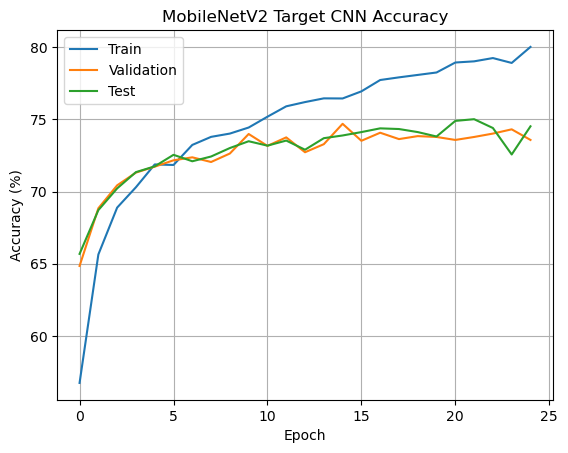

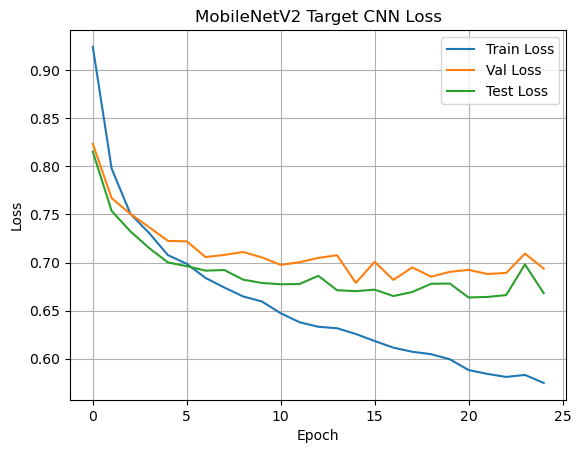

Using device: cuda
Classes: ['happy', 'neutral', 'sad']
Epoch 1: Train=63.37% | Val=68.72% | Test=69.06% || TL=0.834 VL=0.737 TeL=0.741
Epoch 2: Train=71.60% | Val=72.28% | Test=72.52% || TL=0.708 VL=0.705 TeL=0.692
Epoch 3: Train=73.29% | Val=72.75% | Test=74.68% || TL=0.670 VL=0.678 TeL=0.662
Epoch 4: Train=75.04% | Val=73.13% | Test=75.13% || TL=0.649 VL=0.677 TeL=0.660
Epoch 5: Train=76.37% | Val=73.40% | Test=75.51% || TL=0.626 VL=0.678 TeL=0.653
Epoch 6: Train=76.88% | Val=74.07% | Test=75.53% || TL=0.616 VL=0.655 TeL=0.638
Epoch 7: Train=78.08% | Val=72.66% | Test=74.92% || TL=0.604 VL=0.681 TeL=0.649
Epoch 8: Train=78.70% | Val=73.90% | Test=75.69% || TL=0.581 VL=0.666 TeL=0.653
Epoch 9: Train=79.74% | Val=74.02% | Test=75.13% || TL=0.573 VL=0.660 TeL=0.649
Epoch 10: Train=79.70% | Val=74.31% | Test=76.61% || TL=0.561 VL=0.660 TeL=0.648
Epoch 11: Train=80.69% | Val=74.46% | Test=76.73% || TL=0.553 VL=0.656 TeL=0.633
Early stopping triggered
Best model saved: /home/student/Downl

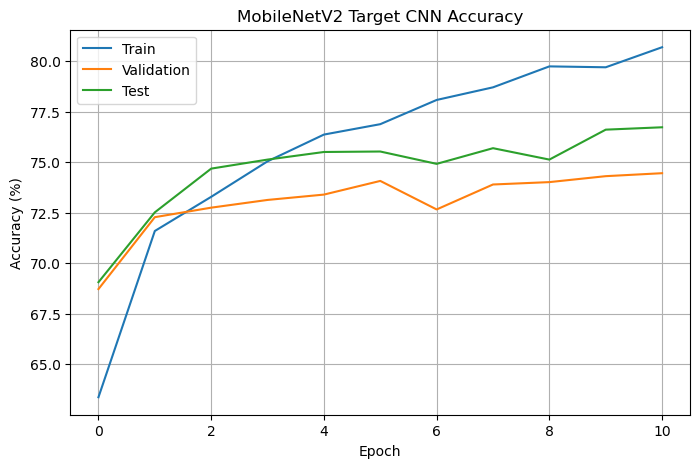

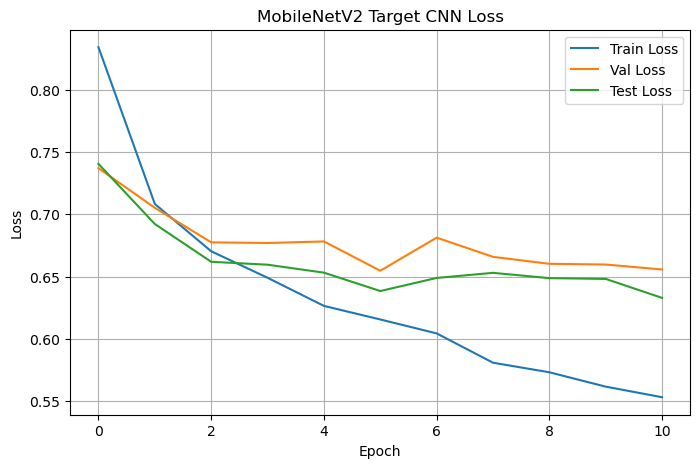

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# PATHS
TRAIN_DIR = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/train"
TEST_DIR  = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/test"
SAVE_PATH = "/home/student/Downloads/copycat_fer_project/target_mobilenetv2_3class.pth"

# CONFIG

BATCH_SIZE = 64
EPOCHS = 30
LR = 5e-4
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

# TRANSFORMS
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# DATASETS
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tf)

print("Classes:", full_train.classes)

val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# MODEL
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),  
    nn.Linear(model.last_channel, NUM_CLASSES)
)

model = model.to(DEVICE)

# PARTIAL UNFREEZE (3 BLOCKS)
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze last 3 blocks
for param in model.features[-1].parameters():
    param.requires_grad = True

for param in model.features[-2].parameters():
    param.requires_grad = True

for param in model.features[-3].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

# LOSS + OPTIMIZER
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=1e-4
)

# EARLY STOPPING SETTINGS
best_val_loss = float("inf")
patience = 5
counter = 0

# METRICS
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

# TRAIN LOOP
for epoch in range(EPOCHS):

    # TRAIN 
    model.train()
    correct, total, running_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    ta = 100 * correct / total
    tl = running_loss / len(train_loader)

    #VALIDATION
    model.eval()
    vc, vt, vloss = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vloss += loss.item()
            pred = out.argmax(1)
            vc += (pred == y).sum().item()
            vt += y.size(0)

    va = 100 * vc / vt
    vloss /= len(val_loader)

    # TEST 
    tc, tt, tloss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            tloss += loss.item()
            pred = out.argmax(1)
            tc += (pred == y).sum().item()
            tt += y.size(0)

    te = 100 * tc / tt
    tloss /= len(test_loader)

    train_acc.append(ta)
    val_acc.append(va)
    test_acc.append(te)
    train_loss.append(tl)
    val_loss.append(vloss)
    test_loss.append(tloss)

    print(
        f"Epoch {epoch+1}: "
        f"Train={ta:.2f}% | Val={va:.2f}% | Test={te:.2f}% || "
        f"TL={tl:.3f} VL={vloss:.3f} TeL={tloss:.3f}"
    )

    # EARLY STOPPING
    if vloss < best_val_loss:
        best_val_loss = vloss
        counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

print("Best model saved:", SAVE_PATH)

# ACCURACY GRAPH
plt.figure(figsize=(8,5))
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.plot(test_acc, label="Test")
plt.legend()
plt.title("MobileNetV2 Target CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


# LOSS GRAPH
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.title("MobileNetV2 Target CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
